In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
engine = create_engine('sqlite:///cars.db')
df = pd.read_sql('SELECT * FROM cars;', engine)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75253 entries, 0 to 75252
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   name                  75253 non-null  object
 1   price                 75253 non-null  int64 
 2   mpg                   75253 non-null  int64 
 3   mileage               75253 non-null  int64 
 4   num_of_entertainment  75253 non-null  int64 
 5   num_of_safety         75253 non-null  int64 
 6   year                  75253 non-null  int64 
 7   drivetrain            75253 non-null  object
 8   fuel_type             75253 non-null  object
 9   transmission          75253 non-null  object
 10  engine                75253 non-null  object
 11  make                  75253 non-null  object
 12  model                 75253 non-null  object
dtypes: int64(6), object(7)
memory usage: 7.5+ MB


In [4]:
df

,name,price,mpg,mileage,num_of_entertainment,num_of_safety,year,drivetrain,fuel_type,transmission,engine,make,model
0,2012 Acura MDX 3.7L,15995,18,120240,1,3,2012,AWD,Gasoline,Automatic,3.7L,Acura,MDX
1,2018 Volkswagen Tiguan 2.0T S,24985,24,32262,1,3,2018,AWD,Gasoline,Automatic,2.0L,Volkswagen,Tiguan
2,2018 Volkswagen Tiguan 2.0T SE,21104,24,77906,2,4,2018,AWD,Gasoline,Automatic,2.0L,Volkswagen,Tiguan
3,2016 BMW M2 Base,44990,22,19027,2,2,2016,RWD,Gasoline,Automatic,3.0L,BMW,M2
4,2019 Volkswagen Tiguan 2.0T SE,26727,25,21916,2,4,2019,AWD,Gasoline,Automatic,2.0L,Volkswagen,Tiguan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
75248,2014 BMW X1 xDrive 28i,14777,27,74650,1,2,2014,AWD,Gasoline,Automatic,2.0L,BMW,X1
75249,2018 Jeep Grand Cherokee Laredo,34999,21,36539,4,3,2018,4WD,Gasoline,Automatic,3.6L,Jeep,Grand
75250,2015 BMW 550 i,31499,21,46879,2,3,2015,RWD,Gasoline,Automatic,4.4L,BMW,550
75251,2017 Audi A8 L 3.0T,40487,24,51809,3,3,2017,AWD,Gasoline,Automatic,3.0L,Audi,A8


In [5]:
df_num = df.iloc[:, 1:7]
df_num

,price,mpg,mileage,num_of_entertainment,num_of_safety,year
0,15995,18,120240,1,3,2012
1,24985,24,32262,1,3,2018
2,21104,24,77906,2,4,2018
3,44990,22,19027,2,2,2016
4,26727,25,21916,2,4,2019
...,...,...,...,...,...,...
75248,14777,27,74650,1,2,2014
75249,34999,21,36539,4,3,2018
75250,31499,21,46879,2,3,2015
75251,40487,24,51809,3,3,2017


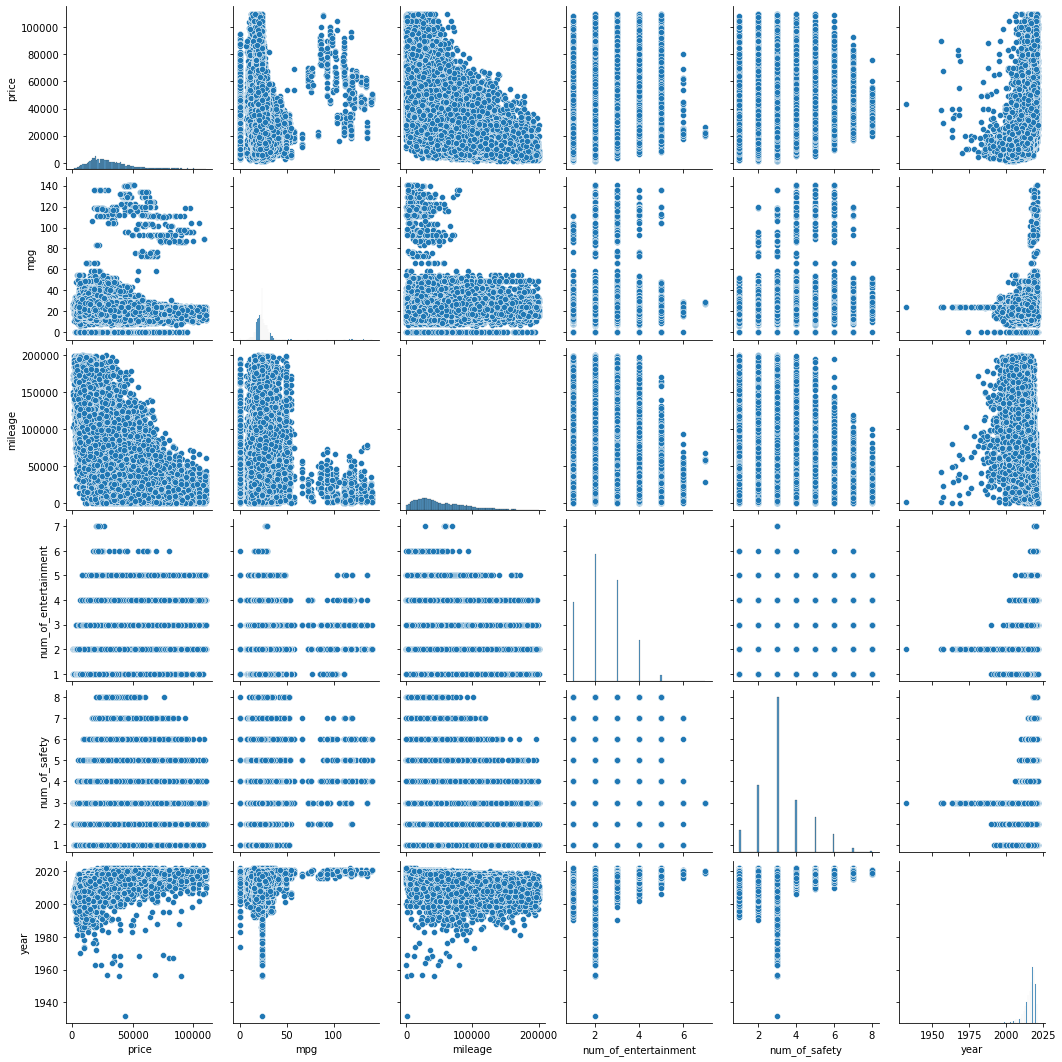

In [6]:
sns.pairplot(df_num)

In [7]:
df_num.corr()

,price,mpg,mileage,num_of_entertainment,num_of_safety,year
price,1.000000,-0.135359,-0.553617,0.336463,0.194505,0.498006
mpg,-0.135359,1.000000,-0.095804,0.026419,0.144863,0.102667
mileage,-0.553617,-0.095804,1.000000,-0.310937,-0.356553,-0.655946
num_of_entertainment,0.336463,0.026419,-0.310937,1.000000,0.357432,0.356814
num_of_safety,0.194505,0.144863,-0.356553,0.357432,1.000000,0.404638
year,0.498006,0.102667,-0.655946,0.356814,0.404638,1.000000


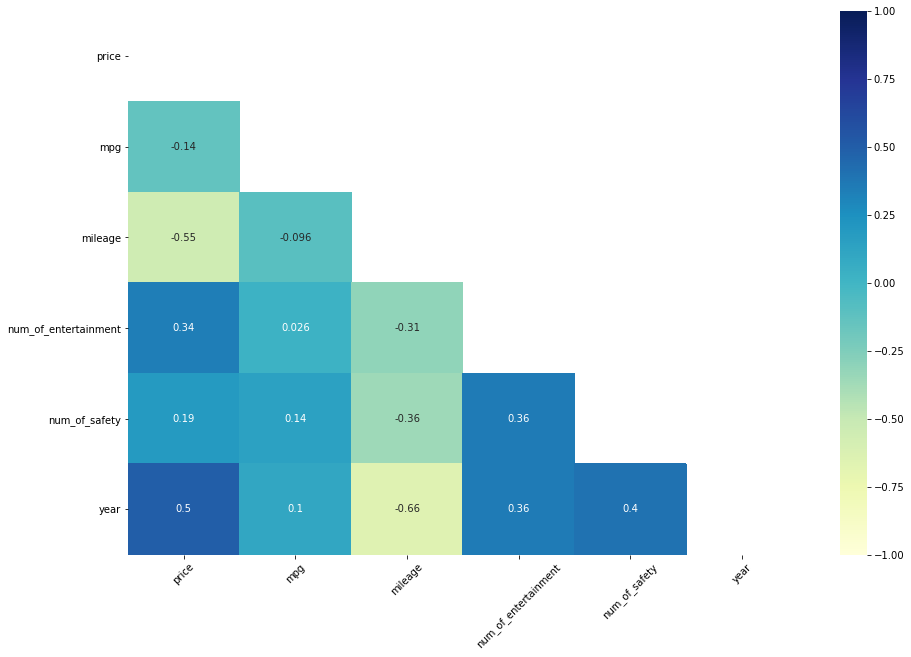

In [8]:
# Plot correlation 
plt.figure(figsize = [15, 10])
upper = np.triu(df_num.corr())
sns.heatmap(df_num.corr(), cmap="YlGnBu", annot=True, vmin=-1, vmax=1, mask=upper)
plt.xticks(rotation = 45)
plt.savefig('heat map.png')

# Base Model

### Only numerical features 

In [9]:
df.head()

,name,price,mpg,mileage,num_of_entertainment,num_of_safety,year,drivetrain,fuel_type,transmission,engine,make,model
0,2012 Acura MDX 3.7L,15995,18,120240,1,3,2012,AWD,Gasoline,Automatic,3.7L,Acura,MDX
1,2018 Volkswagen Tiguan 2.0T S,24985,24,32262,1,3,2018,AWD,Gasoline,Automatic,2.0L,Volkswagen,Tiguan
2,2018 Volkswagen Tiguan 2.0T SE,21104,24,77906,2,4,2018,AWD,Gasoline,Automatic,2.0L,Volkswagen,Tiguan
3,2016 BMW M2 Base,44990,22,19027,2,2,2016,RWD,Gasoline,Automatic,3.0L,BMW,M2
4,2019 Volkswagen Tiguan 2.0T SE,26727,25,21916,2,4,2019,AWD,Gasoline,Automatic,2.0L,Volkswagen,Tiguan


In [10]:
X = df.iloc[:, 2:7]
y = df.price

In [11]:
X

,mpg,mileage,num_of_entertainment,num_of_safety,year
0,18,120240,1,3,2012
1,24,32262,1,3,2018
2,24,77906,2,4,2018
3,22,19027,2,2,2016
4,25,21916,2,4,2019
...,...,...,...,...,...
75248,27,74650,1,2,2014
75249,21,36539,4,3,2018
75250,21,46879,2,3,2015
75251,24,51809,3,3,2017


In [12]:
y

0        15995
1        24985
2        21104
3        44990
4        26727
         ...  
75248    14777
75249    34999
75250    31499
75251    40487
75252     5999
Name: price, Length: 75253, dtype: int64

In [13]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=42)
    
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
    
train_score = rf.score(X_train, y_train)
val_score = rf.score(X_val, y_val)
test_score = rf.score(X_test, y_test)
    
print(f'Train R^2: {train_score:.3f}')
print(f'Validation R^2: {val_score:.3f}')

Train R^2: 0.943
Validation R^2: 0.592


### Dummify entire df

In [14]:
df.head()

,name,price,mpg,mileage,num_of_entertainment,num_of_safety,year,drivetrain,fuel_type,transmission,engine,make,model
0,2012 Acura MDX 3.7L,15995,18,120240,1,3,2012,AWD,Gasoline,Automatic,3.7L,Acura,MDX
1,2018 Volkswagen Tiguan 2.0T S,24985,24,32262,1,3,2018,AWD,Gasoline,Automatic,2.0L,Volkswagen,Tiguan
2,2018 Volkswagen Tiguan 2.0T SE,21104,24,77906,2,4,2018,AWD,Gasoline,Automatic,2.0L,Volkswagen,Tiguan
3,2016 BMW M2 Base,44990,22,19027,2,2,2016,RWD,Gasoline,Automatic,3.0L,BMW,M2
4,2019 Volkswagen Tiguan 2.0T SE,26727,25,21916,2,4,2019,AWD,Gasoline,Automatic,2.0L,Volkswagen,Tiguan


In [15]:
df = pd.get_dummies(df, columns=['drivetrain', 'fuel_type', 'transmission',
                            'engine', 'make', 'model'], drop_first=True)

In [16]:
df.head()

,name,price,mpg,mileage,num_of_entertainment,num_of_safety,year,drivetrain_AWD,drivetrain_FWD,drivetrain_RWD,...,model_i-MiEV,model_i3,model_i8,model_iA,model_iM,model_iQ,model_tC,model_xA,model_xB,model_xD
0,2012 Acura MDX 3.7L,15995,18,120240,1,3,2012,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2018 Volkswagen Tiguan 2.0T S,24985,24,32262,1,3,2018,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2018 Volkswagen Tiguan 2.0T SE,21104,24,77906,2,4,2018,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2016 BMW M2 Base,44990,22,19027,2,2,2016,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2019 Volkswagen Tiguan 2.0T SE,26727,25,21916,2,4,2019,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
X = df.drop(['name', 'price'], axis=1)
y = df.price

In [18]:
X

,mpg,mileage,num_of_entertainment,num_of_safety,year,drivetrain_AWD,drivetrain_FWD,drivetrain_RWD,fuel_type_Electric,fuel_type_Flex,...,model_i-MiEV,model_i3,model_i8,model_iA,model_iM,model_iQ,model_tC,model_xA,model_xB,model_xD
0,18,120240,1,3,2012,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,24,32262,1,3,2018,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,24,77906,2,4,2018,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22,19027,2,2,2016,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,25,21916,2,4,2019,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75248,27,74650,1,2,2014,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75249,21,36539,4,3,2018,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75250,21,46879,2,3,2015,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
75251,24,51809,3,3,2017,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
y

0        15995
1        24985
2        21104
3        44990
4        26727
         ...  
75248    14777
75249    34999
75250    31499
75251    40487
75252     5999
Name: price, Length: 75253, dtype: int64

In [20]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=42)
    
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
    
train_score = rf.score(X_train, y_train)
val_score = rf.score(X_val, y_val)
test_score = rf.score(X_test, y_test)
    
print(f'Train R^2: {train_score:.3f}')
print(f'Validation R^2: {val_score:.3f}')

Train R^2: 0.989
Validation R^2: 0.924


In [21]:
# save rf model
with open('rf_base_model', 'wb') as to_write:
    pickle.dump(rf, to_write)

# Hyperparameter tuning

In [64]:
df

,name,price,mpg,mileage,num_of_entertainment,num_of_safety,year,drivetrain_AWD,drivetrain_FWD,drivetrain_RWD,...,model_i-MiEV,model_i3,model_i8,model_iA,model_iM,model_iQ,model_tC,model_xA,model_xB,model_xD
0,2012 Acura MDX 3.7L,15995,18,120240,1,3,2012,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2018 Volkswagen Tiguan 2.0T S,24985,24,32262,1,3,2018,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2018 Volkswagen Tiguan 2.0T SE,21104,24,77906,2,4,2018,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2016 BMW M2 Base,44990,22,19027,2,2,2016,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2019 Volkswagen Tiguan 2.0T SE,26727,25,21916,2,4,2019,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75248,2014 BMW X1 xDrive 28i,14777,27,74650,1,2,2014,1,0,0,...,0,0,0,0,0,0,0,0,0,0
75249,2018 Jeep Grand Cherokee Laredo,34999,21,36539,4,3,2018,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75250,2015 BMW 550 i,31499,21,46879,2,3,2015,0,0,1,...,0,0,0,0,0,0,0,0,0,0
75251,2017 Audi A8 L 3.0T,40487,24,51809,3,3,2017,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
X = df.drop(['name', 'price'], axis=1)
y = df.price

In [66]:
X

,mpg,mileage,num_of_entertainment,num_of_safety,year,drivetrain_AWD,drivetrain_FWD,drivetrain_RWD,fuel_type_Electric,fuel_type_Flex,...,model_i-MiEV,model_i3,model_i8,model_iA,model_iM,model_iQ,model_tC,model_xA,model_xB,model_xD
0,18,120240,1,3,2012,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,24,32262,1,3,2018,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,24,77906,2,4,2018,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22,19027,2,2,2016,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,25,21916,2,4,2019,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75248,27,74650,1,2,2014,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75249,21,36539,4,3,2018,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
75250,21,46879,2,3,2015,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
75251,24,51809,3,3,2017,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
y

0        15995
1        24985
2        21104
3        44990
4        26727
         ...  
75248    14777
75249    34999
75250    31499
75251    40487
75252     5999
Name: price, Length: 75253, dtype: int64

In [68]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=42)

In [28]:
rf_s = RandomForestRegressor()

n_estimators = [500]
max_depth = [None, 30, 100, 200, 300, 400, 500]
min_samples_split = [2, 5, 10, 15]
max_features = ['log2']

param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, 
                  min_samples_split=min_samples_split, 
                  max_features=max_features)

grid_rf = GridSearchCV(rf_s, param_grid, cv=5, scoring='r2')
grid_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 30, 100, 200, 300, 400, 500],
                         'max_features': ['log2'],
                         'min_samples_split': [2, 5, 10, 15],
                         'n_estimators': [500]},
             scoring='r2')

In [29]:
print('Best params: ', grid_rf.best_params_)
print('Best estimator: ', grid_rf.best_estimator_)
print('Best score: ', grid_rf.best_score_)

Best params:  {'max_depth': 200, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 500}
Best estimator:  RandomForestRegressor(max_depth=200, max_features='log2', n_estimators=500)
Best score:  0.9303743692057042


In [31]:
rf_t = RandomForestRegressor(max_depth=200, max_features='log2',
                             min_samples_split=2, n_estimators=500)
rf_t.fit(X_train, y_train)

RandomForestRegressor(max_depth=200, max_features='log2', n_estimators=500)

In [32]:
train_score_t = rf_t.score(X_train, y_train)

print(f'Train R^2: {train_score_t:.3f}')

Train R^2: 0.991


In [33]:
val_score_t = rf_t.score(X_val, y_val)

print(f'Validation R^2: {val_score_t:.3f}')

Validation R^2: 0.932


In [45]:
# Safe the model
with open('rf_tuned_model', 'wb') as to_write:
    pickle.dump(rf_t, to_write)

# Test result with tuned model 

In [51]:
rf_t.fit(X, y)

RandomForestRegressor(max_depth=200, max_features='log2', n_estimators=500)

In [73]:
train_score_final = rf_t.score(X, y)

print(f'Train R^2: {train_score_final:.3f}')

Train R^2: 0.992


In [53]:
test_score_final = rf_t.score(X_test, y_test)

print(f'Test R^2: {test_score_final:.3f}')

Test R^2: 0.939


In [54]:
# RMSE
RMSE = np.sqrt(np.mean((y_test - rf_t.predict(X_test))**2))

print(f'RMSE: {RMSE:.3f}')

RMSE: 4141.341


In [55]:
# MAE
MAE = np.mean(np.abs(y_test - rf_t.predict(X_test)))

print(f'MAE: {MAE:.3f}')

MAE: 2671.649


### Diagnostic Plot

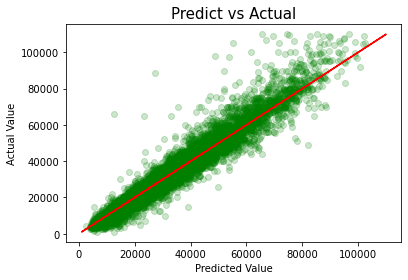

In [75]:
plt.scatter(rf_t.predict(X_test), y_test, alpha=0.2, c='g')
plt.plot(y_test, y_test, c='r')
plt.title('Predict vs Actual', fontsize=15)
plt.xlabel('Predicted Value', fontsize=10)
plt.ylabel('Actual Value', fontsize=10)

Text(0, 0.5, 'Residuals')

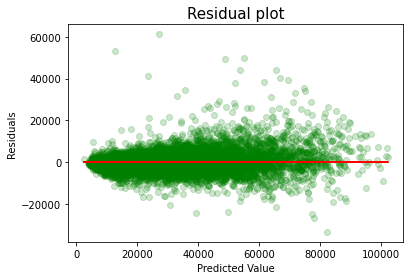

In [77]:
res = y_test - rf_t.predict(X_test)
plt.scatter(rf_t.predict(X_test), res, alpha=0.2, c='g')
plt.plot(rf_t.predict(X_test), np.zeros((15051,)), c='r')
plt.title("Residual plot", fontsize=15)
plt.xlabel("Predicted Value", fontsize=10)
plt.ylabel("Residuals", fontsize=10)

In [69]:
# Safe the model
with open('rf_final_model', 'wb') as to_write:
    pickle.dump(rf_t, to_write)

# Make Predictions

In [56]:
pred = rf_t.predict(X_test)

In [57]:
X_test.head()

,mpg,mileage,num_of_entertainment,num_of_safety,year,drivetrain_AWD,drivetrain_FWD,drivetrain_RWD,fuel_type_Electric,fuel_type_Flex,...,model_i-MiEV,model_i3,model_i8,model_iA,model_iM,model_iQ,model_tC,model_xA,model_xB,model_xD
66472,18,26704,2,3,2019,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53985,25,85600,1,3,2017,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12141,23,97433,4,4,2016,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12496,19,20490,2,3,2011,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52888,22,103761,1,3,2016,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
pred[:3]

array([44896.43 , 18493.648, 24233.876])

In [59]:
df.loc[66472]

name                    2019 Toyota 4Runner TRD Off Road
price                                              44995
mpg                                                   18
mileage                                            26704
num_of_entertainment                                   2
                                      ...               
model_iQ                                               0
model_tC                                               0
model_xA                                               0
model_xB                                               0
model_xD                                               0
Name: 66472, Length: 805, dtype: object

In [60]:
df.loc[53985]

name                    2017 Jeep Cherokee Latitude
price                                         18990
mpg                                              25
mileage                                       85600
num_of_entertainment                              1
                                   ...             
model_iQ                                          0
model_tC                                          0
model_xA                                          0
model_xB                                          0
model_xD                                          0
Name: 53985, Length: 805, dtype: object